In [ ]:
import pandas as pd
import requests
import numpy as np
from bs4 import BeautifulSoup
import yfinance as yf
import itertools
import matplotlib.pyplot as plt
import networkx as nx
import statsmodels.api as sm
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
import sys
import scipy
from sklearn.model_selection import train_test_split, LeaveOneOut, cross_val_score, KFold
from sklearn.cluster import KMeans
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import linkage,fcluster
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import to_tree
from sklearn.cluster import DBSCAN
from scipy.sparse.linalg import eigsh

In [ ]:
#S&P500
wikiurl="https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
table_class="wikitable sortable jquery-tablesorter"
response=requests.get(wikiurl)

soup = BeautifulSoup(response.text, 'html.parser')
indiatable=soup.find_all('table',{'class':"wikitable"})


df=pd.read_html(str(indiatable))

df=pd.DataFrame(df[0])
df = df.sort_values("Symbol")

all_symbol = " ".join(df["Symbol"].values)

tmp_info = yf.Tickers(all_symbol)
data = yf.download(all_symbol, start="2018-01-01", end="2023-12-31")

tmp_info = yf.Tickers(all_symbol)
data_info = pd.DataFrame([tmp_info.tickers[tmp_symbol].info for tmp_symbol in df["Symbol"].values])
data_info.index = df["Symbol"].values

data_daily_prices = data["Adj Close"]
tmp_na_count = data_daily_prices.isna().sum()
data_daily_prices2 = data_daily_prices.loc[:,tmp_na_count==0]
data_info2 = data_info.loc[tmp_na_count==0,:]

SP500_daily_price = data_daily_prices2
SP500_daily_returns = SP500_daily_price.pct_change()
SP500_daily_returns = SP500_daily_returns.iloc[1:, :]

[*********************100%%**********************]  503 of 503 completed
ERROR:yfinance:
2 Failed downloads:
ERROR:yfinance:['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2018-01-01 -> 2023-12-31)')
ERROR:yfinance:['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')


In [ ]:
#purning network
def adjaceny(data,upper,lower):
  cor = data.corr()
  cor[(cor > 0) & (cor < upper)] = 0
  cor[(cor < 0) & (cor > lower)] = 0
  return cor

#Cumlative return
def cumulative_return(data):
  df = (data+1).prod() - 1
  return df

#Calculate Prob
def softmax(adjaceny , cumlative_return):
 index = adjaceny.copy()
 col = index.shape[0]
 Index = adjaceny.index
 result = []
 for i in range(col):
  prob = np.zeros_like(cumlative_return)
  neighbor_return = cumlative_return[index.iloc[i,:] == 1]
  sum_neighbor = np.sum(np.exp(neighbor_return))
  for j in range(col):
    if index.iloc[i,j] == 1:
      prob[j] = np.exp(cumlative_return[j]) / sum_neighbor
  result.append(prob)
 result = pd.DataFrame(result, index = Index, columns = Index)
 return result

#counts visit of each nodes
def walk_counts(transaction,k):
  num_nodes = transaction.shape[0]
  counts = np.zeros(num_nodes,dtype = int)
  current_node = np.random.randint(num_nodes)
  counts[current_node] += 1
  while k > 0 :
    next_node = np.random.choice(num_nodes, p=transaction.iloc[current_node])
    counts[next_node] += 1
    current_node = next_node
    k -= 1
  counts = pd.DataFrame(counts,index = transaction.index)
  return counts

In [ ]:
# 给定的邻接矩阵
def premutaion_adjaceny(M):
  Index = M.index
  M = M.values
  G = nx.from_numpy_array(M)

  connected_subgraphs = sorted(list(nx.connected_components(G)), key=len)

  new_nodes = []

  node_mapping = {}


  new_node_id = 0
  for subgraph in connected_subgraphs:
      for node in subgraph:
          node_mapping[node] = new_node_id
          new_nodes.append(node)
          new_node_id += 1

  new_connected_subgraphs = []

  for subgraph in connected_subgraphs:
      new_subgraph = set()
      for node in subgraph:
          new_subgraph.add(node_mapping[node])
      new_connected_subgraphs.append(new_subgraph)

  new_edges = []
  edges = G.edges()
  for edge in edges:
      new_edge = tuple(node_mapping[node] for node in edge)
      new_edges.append(new_edge)

  new_A = np.zeros_like(M)
  for edge in new_edges:
      new_A[edge[0], edge[1]] = 1
      new_A[edge[1], edge[0]] = 1

  new_index = [None] * len(Index)

  for node, new_node_id in node_mapping.items():
    new_index[new_node_id] = node

  new_index = Index[new_index]
  new_A = pd.DataFrame(new_A,index = new_index, columns = new_index)
  return new_A, new_index

In [ ]:
def SNPA_return(daily_returns,upper,lower,walk_times,num_of_assets):
  cumulative = cumulative_return(daily_returns)
  M = adjaceny(daily_returns, upper, lower )
  M,new_index = premutaion_adjaceny(M)
  cumulative = cumulative[new_index]
  transaction = pd.DataFrame(softmax(M , cumulative))
  visits = walk_counts(transaction, walk_times)
  leng = len(visits)
  if num_of_assets is not None:
    top_indices = np.argsort(visits)[-num_of_assets:]
    sum_top_visits = np.sum(visits[top_indices])
    max_weighted = np.zeros(leng)
    for j in top_indices:
        max_weighted[j] = visits[j] / sum_top_visits
  else:
    num = np.arange(1,leng+1)
    max_return = float('-inf')
    max_weighted = None
    for i in num:
      top_indices = np.argsort(visits)[-i:]
      sum_top_visits = np.sum(visits[top_indices])
      weighted = np.zeros(leng)
      for j in top_indices:
        weighted[j] = visits[j] / sum_top_visits
      return_i = np.dot(weighted , cumulative)
      if return_i > max_return:
          max_return = return_i
          max_weighted = weighted
  return transaction, visits, max_weighted

# Stable

In [ ]:
# 给定的邻接矩阵
def premutaion_adjaceny1(M):
  M = M
  G = nx.from_numpy_array(M)

  connected_subgraphs = sorted(list(nx.connected_components(G)), key=len)

  new_nodes = []

  node_mapping = {}


  new_node_id = 0
  for subgraph in connected_subgraphs:
      for node in subgraph:
          node_mapping[node] = new_node_id
          new_nodes.append(node)
          new_node_id += 1

  new_connected_subgraphs = []

  for subgraph in connected_subgraphs:
      new_subgraph = set()
      for node in subgraph:
          new_subgraph.add(node_mapping[node])
      new_connected_subgraphs.append(new_subgraph)

  new_edges = []
  edges = G.edges()
  for edge in edges:
      new_edge = tuple(node_mapping[node] for node in edge)
      new_edges.append(new_edge)

  new_A = np.zeros_like(M)
  for edge in new_edges:
      new_A[edge[0], edge[1]] = 1
      new_A[edge[1], edge[0]] = 1

  return new_A

In [ ]:
A = np.array([      [0, 1, 0, 0, 0, 1],
              [1, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 1, 0],
              [0, 0, 0, 1, 0, 0],
              [1, 0, 0, 0, 0, 0]])
premutaion_adjaceny1(A)

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 0]])

In [ ]:
cumulative = cumulative_return(train[0])
M =  adjaceny(train[0],0.8,-0.5)
M,new_index = premutaion_adjaceny(M)
cumulative = cumulative[new_index]
transaction = pd.DataFrame(softmax(M , cumulative))
visits = walk_counts(transaction, 10000)

In [ ]:
G = nx.from_numpy_array(transaction.values)
nodes = max(G.nodes()) + 1

stable = []
connected_subgraphs = sorted(list(nx.connected_components(G)), key=len)
for subgraph in connected_subgraphs:
    # 提取子矩阵的索引
    subgraph_indices = [list(subgraph), list(subgraph)]

    # 提取子矩阵
    submatrix = transaction.values[np.ix_(*subgraph_indices)]

    # 计算特征值
    values, vectors = np.linalg.eig(submatrix.T)

    # 检查特征值是否接近1
    ones_indices = np.isclose(values, 1) & np.isclose(np.imag(values), 0)

    weight = len(subgraph) / nodes

    vector = vectors[:, ones_indices]
    stable.append((weight * vector).tolist())
    print(np.sum(vector))
stable = np.vstack(stable)

In [ ]:
connected_subgraphs

In [ ]:
values, vectors = np.linalg.eig(submatrix.T)
values

array([ 1.00000000e+00+0.00000000e+00j,  8.97190067e-01+0.00000000e+00j,
        8.48833276e-01+0.00000000e+00j,  7.10595234e-01+0.00000000e+00j,
        4.54861047e-01+0.00000000e+00j, -2.83730686e-01+0.00000000e+00j,
        3.38280716e-01+0.00000000e+00j,  3.00169751e-01+0.00000000e+00j,
        2.61125801e-01+0.00000000e+00j,  1.50873558e-01+0.00000000e+00j,
        7.85645971e-02+0.00000000e+00j, -1.62245197e-01+0.00000000e+00j,
       -1.46148172e-01+0.00000000e+00j, -1.34881594e-01+0.00000000e+00j,
       -7.92170645e-02+0.00000000e+00j, -4.38385683e-02+0.00000000e+00j,
       -7.39035171e-17+0.00000000e+00j, -1.22281994e-17+0.00000000e+00j,
       -1.79712545e-18+1.13404667e-17j, -1.79712545e-18-1.13404667e-17j,
        2.51218938e-17+0.00000000e+00j])

In [ ]:
vectors[:,0]

array([-0.34324019+0.j, -0.06608215+0.j, -0.29198246+0.j, -0.14685986+0.j,
       -0.10374668+0.j, -0.24456631+0.j, -0.06008838+0.j, -0.08572432+0.j,
       -0.09508878+0.j, -0.08850201+0.j, -0.06605964+0.j, -0.27110973+0.j,
       -0.23699825+0.j, -0.290185  +0.j, -0.12622378+0.j, -0.26226814+0.j,
       -0.32344018+0.j, -0.07864525+0.j, -0.31979988+0.j, -0.3093454 +0.j,
       -0.24671013+0.j])

In [ ]:
np.sum(submatrix,axis = 1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1.])

# Pervious 12 month,0.8,-0.5,4000,2019-2020

In [ ]:
def split_dataset(data,start,end):
    split_sets = []

    split_sets.append(data[data.index.year == start])

    start_month = 1
    start_year = start
    end_month = 1
    end_year = end

    while end_year < max(data.index.year):
        end_month += 1
        start_month += 1
        if start_month >12:
          start_month = 1
          start_year += 1
          if end_month > 12:
            end_month = 1
            end_year += 1
        if start_year > end-1:
          break
        split_sets.append(data[(data.index >= f"{start_year}-{start_month:02d}-01") & (data.index < f"{end_year}-{end_month:02d}-01")])

    return split_sets

In [ ]:
train = split_dataset(SP500_daily_returns,2018,2020)
test = split_dataset(SP500_daily_price,2019,2021)

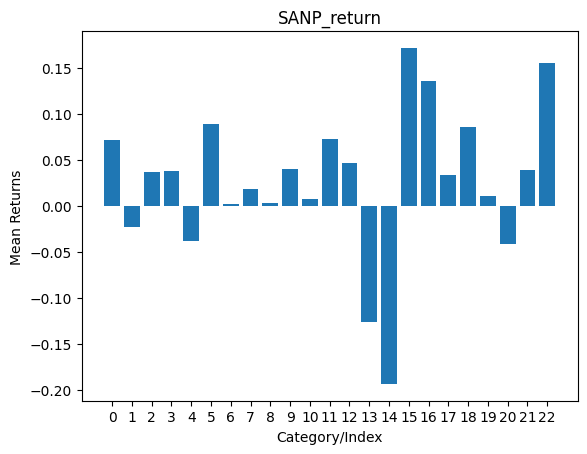

In [ ]:
all_optwt = []
all_Transaction = []
all_Visits = []

for _ in range(10):
    optwt = []
    Transaction = []
    Visits = []

    for i in train:
        P, R, wt = SNPA_return(i, 0.8, -0.5, 4000, None)
        optwt.append(wt)
        Transaction.append(P)
        Visits.append(R)

    all_optwt.append(optwt)
    all_Transaction.append(Transaction)
    all_Visits.append(Visits)

all_SNPA_period_return = []
all_SNPA_sharpe = []

for optwt in all_optwt:
    period_return = []
    inital_Capital = 1
    sharpe = []
    for i in range(23):
        each_stock = inital_Capital * optwt[i] / test[i].iloc[1,:]
        Capital = np.dot(each_stock, test[i+1].iloc[1,:])
        rate = (Capital/inital_Capital)-1
        Capital = inital_Capital
        cov = test[i].cov()
        risk = optwt[i]@cov@optwt[i]
        shar = rate/risk
        sharpe.append(shar)
        period_return.append(rate)

    all_SNPA_sharpe.append(sharpe)
    all_SNPA_period_return.append(period_return)

SNPA_mean_returns = np.zeros(23)
for each_return in all_SNPA_period_return:
    each_return_adj = np.array(each_return)
    SNPA_mean_returns = SNPA_mean_returns + each_return_adj
SNPA_mean_returns = SNPA_mean_returns/len(all_SNPA_period_return)

x_values = np.arange(len(SNPA_mean_returns))
plt.bar(x_values, SNPA_mean_returns)
plt.title('SANP_return')
plt.xlabel('Category/Index')
plt.ylabel('Mean Returns')
plt.xticks(x_values)
plt.show()

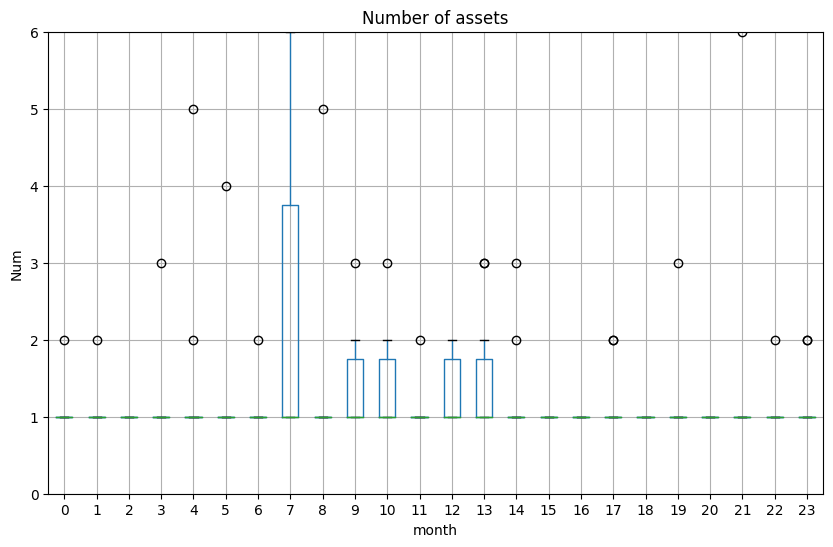

In [ ]:
v = []
for i in all_optwt:
  v1 = []
  for j in i:
    v1.append(np.sum(j != 0))
  v.append(v1)

v = pd.DataFrame(v)

plt.figure(figsize=(10, 6))
v.boxplot()
plt.xticks(range(1, len(v.columns) + 1), v.columns)
plt.xlabel('month')
plt.ylabel('Num')
plt.ylim(0,6)
plt.title('Number of assets')
plt.show()

In [ ]:
SNPA_mean_sharpe = np.zeros(23)
for each_sharpe in all_SNPA_sharpe:
    each_sharpe_adj = np.array(each_sharpe)
    SNPA_mean_sharpe = SNPA_mean_sharpe + each_sharpe_adj
SNPA_mean_sharpe = SNPA_mean_sharpe/len(SNPA_mean_sharpe)

# Pagerank

In [ ]:
all_page = []
for period in all_Transaction:
  empircal = []
  for p in period:
    transition_graph = nx.from_pandas_adjacency(p, create_using=nx.DiGraph)
    pagerank_scores = nx.pagerank(transition_graph)
    page_v = list(pagerank_scores.values())
    empircal.append(page_v)
  all_page.append(empircal)

In [ ]:
all_rank = []
for period in all_Visits:
  empircal = []
  for p in period:
    visit_ratio = np.array(p / np.sum(p))
    empircal.append(visit_ratio)
  all_rank.append(empircal)

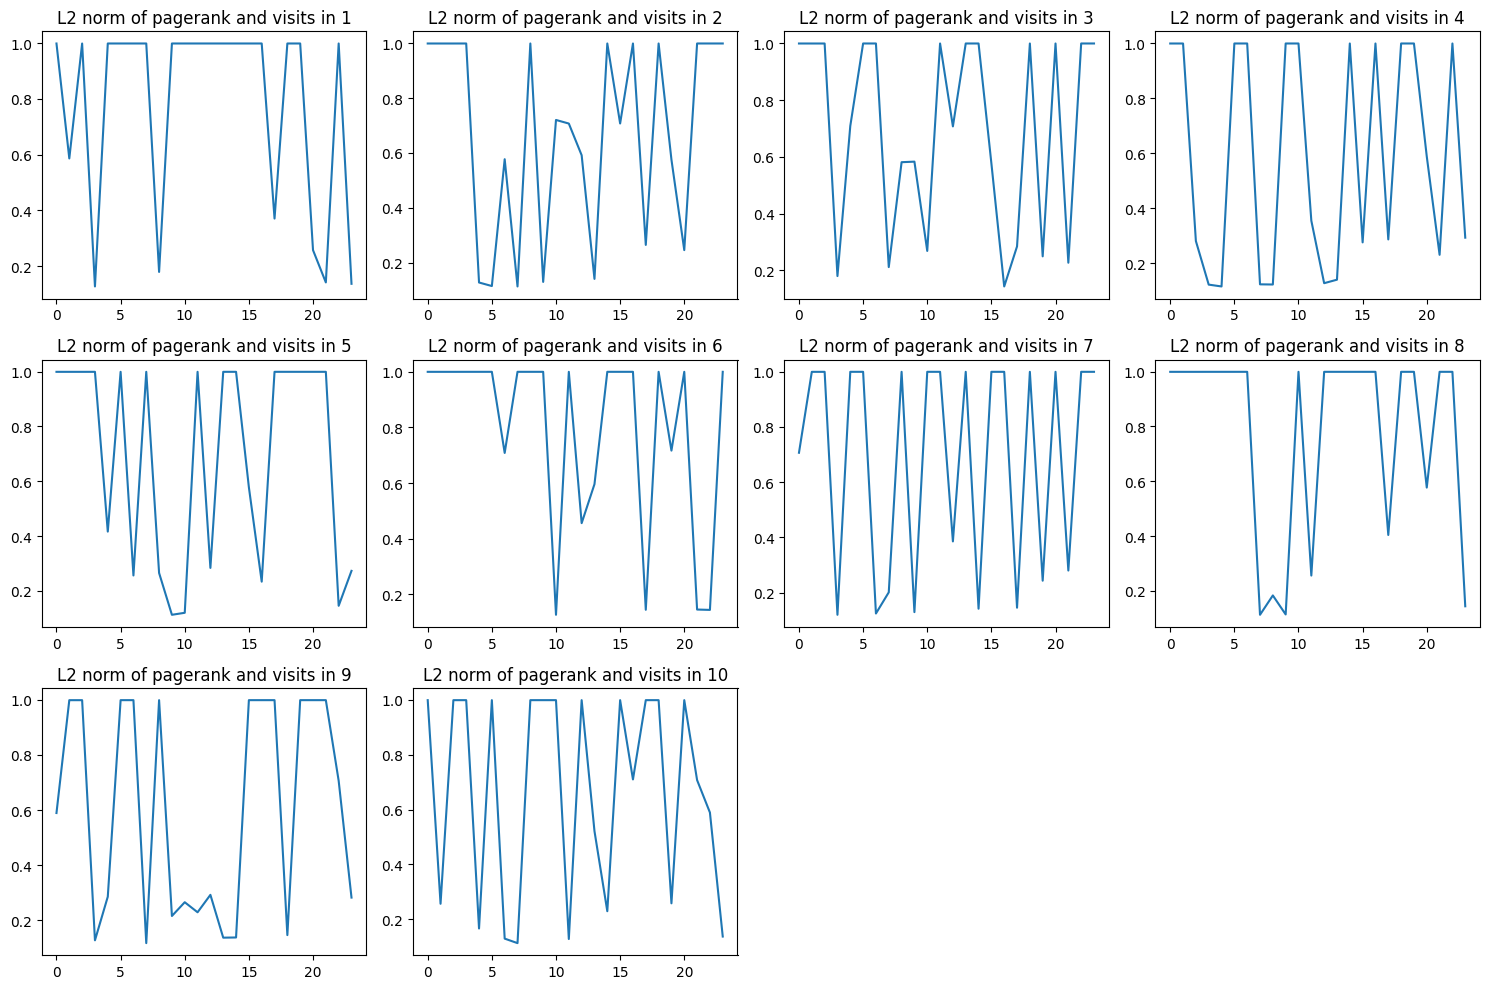

In [ ]:
def compute_distance(v1, v2):
    diff = v1 - v2
    distance = np.linalg.norm(diff)
    return distance

page_visit_distances = []

for page_vectors, rank_vectors in zip(all_page, all_rank):
    period_distances = []
    for page, rank in zip(page_vectors, rank_vectors):
        distance = compute_distance(page, rank)
        period_distances.append(distance)
    page_visit_distances.append(period_distances)

plt.figure(figsize=(15, 10))
for i in range(10):
    plt.subplot(3, 4, i+1)
    plt.plot(page_visit_distances[i])
    plt.title(f'L2 norm of pagerank and visits in {i+1}')

plt.tight_layout()
plt.show()

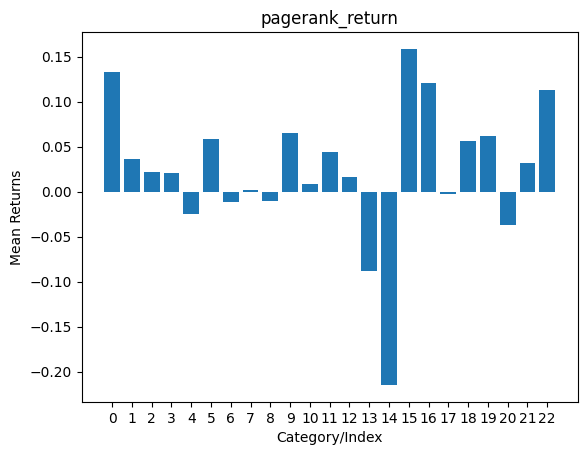

In [ ]:
all_pagerank_sharpe = []
all_pagerank_period_return = []

for page in all_page:
    period_return = []
    inital_Capital = 1
    sharpe = []
    for i in range(23):
        each_stock = inital_Capital * page[i] / test[i].iloc[1,:]
        Capital = np.dot(each_stock, test[i+1].iloc[1,:])
        rate = (Capital/inital_Capital)-1
        Capital = inital_Capital
        cov = test[i].cov()
        risk = optwt[i]@cov@optwt[i]
        shar = rate/risk
        sharpe.append(shar)
        period_return.append(rate)

    all_pagerank_sharpe.append(sharpe)
    all_pagerank_period_return.append(period_return)

pagerank_mean_returns = np.zeros(23)
for each_return in all_pagerank_period_return:
    each_return_adj = np.array(each_return)
    pagerank_mean_returns = pagerank_mean_returns + each_return_adj
pagerank_mean_returns = pagerank_mean_returns/len(all_pagerank_period_return)

x_values = np.arange(len(pagerank_mean_returns))
plt.bar(x_values, pagerank_mean_returns)
plt.title('pagerank_return')
plt.xlabel('Category/Index')
plt.ylabel('Mean Returns')
plt.xticks(x_values)
plt.show()

In [ ]:
compute_distance(SNPA_mean_returns, pagerank_mean_returns)

0.14404909570175153

In [ ]:
import numpy as np
import networkx as nx

# 给定的邻接矩阵
A = adjaceny(train[0],0.8,-0.5).values
G = nx.from_numpy_array(A)

connected_subgraphs = sorted(list(nx.connected_components(G)), key=len)

new_nodes = []

node_mapping = {}


new_node_id = 0
for subgraph in connected_subgraphs:
    for node in subgraph:
        node_mapping[node] = new_node_id
        new_nodes.append(node)
        new_node_id += 1

new_connected_subgraphs = []

for subgraph in connected_subgraphs:
    new_subgraph = set()
    for node in subgraph:
        new_subgraph.add(node_mapping[node])
    new_connected_subgraphs.append(new_subgraph)

new_edges = []
edges = G.edges()
for edge in edges:
    new_edge = tuple(node_mapping[node] for node in edge)
    new_edges.append(new_edge)

new_A = np.zeros_like(A)
for edge in new_edges:
    new_A[edge[0], edge[1]] = 1
    new_A[edge[1], edge[0]] = 1

In [ ]:
A = np.array([[0, 1, 0, 0, 0, 1],
              [1, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 1, 0],
              [0, 0, 0, 1, 0, 0],
              [1, 0, 0, 0, 0, 0]]

In [ ]:
all_stable = []
for period in all_Transaction:
  stable = []
  for p in period:
    values,vecs = np.linalg.eig(p.T)
    vec = vecs[:, values == 1]
    stable.append(vec)
  all_stable.append(stable)

stable_visit_distances = []

for stable_vectors, rank_vectors in zip(all_stable, all_rank):
    period_distances = []
    for stable, rank in zip(stable_vectors, rank_vectors):
        distance = compute_distance(stable, rank)
        period_distances.append(distance)
    stable_visit_distances.append(period_distances)

plt.figure(figsize=(15, 10))
for i in range(10):
    plt.subplot(3, 4, i+1)
    plt.plot(stable_visit_distances[i])
    plt.title(f'L2 norm of pagerank and visits in {i+1}')

plt.tight_layout()
plt.show()

ValueError: operands could not be broadcast together with shapes (487,356) (487,) 

In [ ]:
import networkx as nx
all_Pagerank = []
for Period in all_Transaction:
  pagerank = []
  for p in Period:
   G = nx.DiGraph(p)
   vec = nx.pagerank(G)
   vec = np.array(list(vec.values()))
   pagerank.append(vec)
  all_Pagerank.append(pagerank)

#RHO dependence

In [ ]:
def centraility(daily_returns,upper,low):
  M = adjaceny(daily_returns, upper, low )
  M = np.where( M != 0, 1, 0)
  eigenvalues, eigenvectors = np.linalg.eig(M)
  return np.abs(eigenvectors[:,0])

def sharp(daily_returns):
  mean_daily_returns = np.mean(daily_returns, axis=0)
  std_daily_returns = np.std(daily_returns, axis=0)
  annualized_mean_returns = mean_daily_returns * 250
  annualized_std_returns = std_daily_returns * np.sqrt(250)
  sharpes = annualized_mean_returns / annualized_std_returns
  return sharpes

In [ ]:
rhowt = []
for i in window:
  daily_return = i.pct_change()
  cn = centraility(daily_return,0.2,-0.3)
  sharpe = sharp(daily_return)
  cor = np.corrcoef(sharpe, cn)[0, 1]
  if cor > 0.2:
    top_20_index = np.argsort(cn)[-20:]
    vector = np.zeros_like(cn)
    vector[top_20_index] = 1 / 20
  else:
    bottom_20_index = np.argsort(cn)[:20]
    vector = np.zeros_like(cn)
    vector[bottom_20_index] = 1 / 20
  rhowt.append(vector)

In [ ]:
rho_return = []
inital_Capital = 1
rho_sharpe = []
for i in range(13):
    each_stock = inital_Capital * rhowt[i] / SP500_daily_price.loc[window[i].index[-1]]
    inital_Capital = np.dot(each_stock, SP500_daily_price.loc[window[i + 1].index[-1]])
    rate = (Capital/inital_Capital)-1
    cov = SP500_daily_price.loc[window[i].index].cov()
    risk = rhowt[i]@cov@rhowt[i]
    sharpe = rate/risk
    Capital = inital_Capital
    rho_sharpe.append(sharpe)
    rho_return.append(rate)


SP500 INDEX

In [ ]:
sp500_data = yf.download('^GSPC', period="10y")

[*********************100%%**********************]  1 of 1 completed


In [ ]:
window = Split_window(sp500_data, 20, 22, 200)
sp500_index = []
for i in window:
    sp500_index.append((i.iloc[-1,5]/i.iloc[0,5])-1)

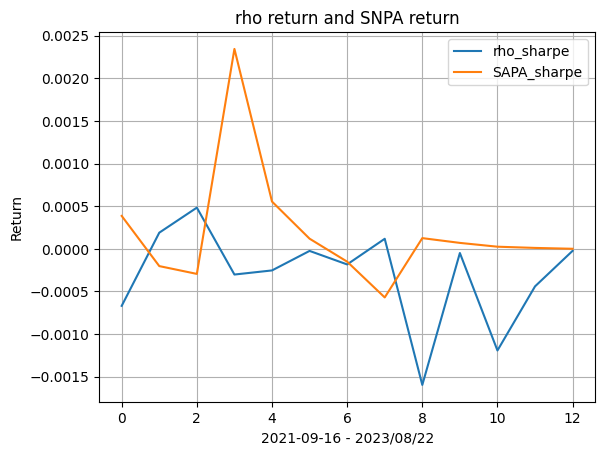

In [ ]:
plt.plot(rho_sharpe, label='rho_sharpe')
plt.plot(SNPA_mean_sharpe, label='SAPA_sharpe')


plt.xlabel('2021-09-16 - 2023/08/22')
plt.ylabel('Return')
plt.title('rho return and SNPA return')
plt.legend()

plt.grid(True)
plt.show()

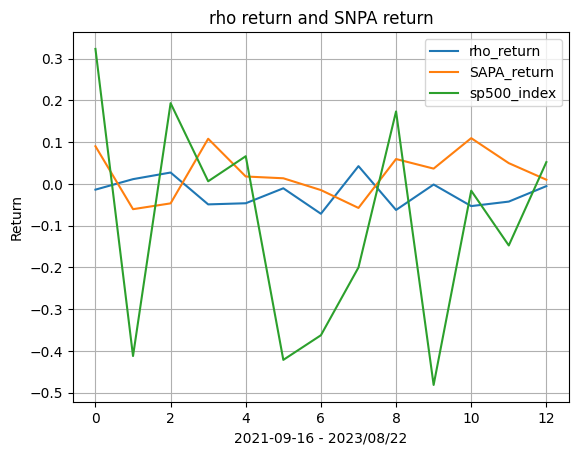

In [ ]:
plt.plot(rho_return, label='rho_return')
plt.plot(SNPA_mean_returns, label='SAPA_return')
plt.plot(sp500_index[0:13],label = 'sp500_index')

plt.xlabel('2021-09-16 - 2023/08/22')
plt.ylabel('Return')
plt.title('rho return and SNPA return')
plt.legend()

plt.grid(True)
plt.show()

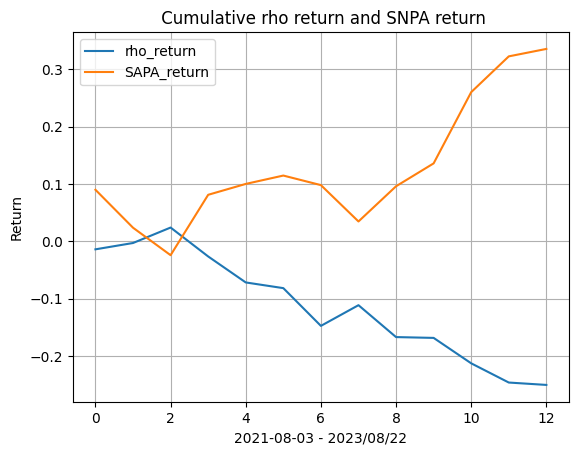

In [ ]:
plt.plot(np.cumprod(np.array(rho_return)+1)-1, label='rho_return')
plt.plot(np.cumprod(np.array(SNPA_mean_returns)+1)-1, label='SAPA_return')

plt.xlabel('2021-08-03 - 2023/08/22')
plt.ylabel('Return')
plt.title(' Cumulative rho return and SNPA return')
plt.legend()

plt.grid(True)
plt.show()